# Solución reto HidroPredictiva.

En la primera celda instalamos la librería *codecarbon*, inicializamos el emission tracker y empezamos la medición.

In [1]:
# Dependencias y codecarbon
!pip install scikit-learn pandas numpy xgboost matplotlib
!pip install codecarbon --quiet
from codecarbon import EmissionsTracker
tracker = EmissionsTracker()
tracker.start()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 8.21.0 requires prompt-toolkit<3.1.0,>=3.0.41, but you have prompt-toolkit 3.0.36 which is incompatible.


[codecarbon INFO @ 17:21:11] [setup] RAM Tracking...
[codecarbon INFO @ 17:21:11] [setup] GPU Tracking...
[codecarbon INFO @ 17:21:11] No GPU found.
[codecarbon INFO @ 17:21:11] [setup] CPU Tracking...
[codecarbon WARNING @ 17:21:11] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 17:21:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 17:21:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 17:21:13] >>> Tracker's metadata:
[codecarbon INFO @ 17:21:13]   Platform system: Linux-5.15.154+-x86_64-with-glibc2.31
[codecarbon INFO @ 17:21:13]   Python version: 3.10.14
[codecarbon INFO @ 17:21:13]   CodeCarbon version: 2.7.1
[codecarbon INFO @ 17:21:13]   Available RAM : 31.358 GB
[codecarbon INFO @ 17:21:13]   CPU count: 4
[codecarbon INFO @ 17:

## Empezamos la transformación del DataFrame para el modelado y el **feature engineering**.

En la segunda celda importamos las librerias que necesitaremos.

In [2]:
from kaggle_secrets import UserSecretsClient
from ast import literal_eval
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import pandas as pd
import numpy as np
from pprint import pprint
from xgboost import XGBRegressor
pd.set_option('mode.chained_assignment', None)

Aquí definimos algunas funciones y variables de utilidad. 
- Necesitamos una función que nos permita calcular la distancia entre los emplazamientos y los puntos en los datos del GFS. 
- Necesitamos funciones que nos den un DataFrame en formato *long*, que nos permita modelar el caudal con una observación por dia.

In [3]:
def distance_in_globe(latlon_reference: tuple[float], latlon: tuple[float]):
    """
    Calcula la distancia entre dos puntos en el globo usando su latitud y longitud.
    
    Parametros:
    
    latlon_reference (tuple[float]): Latitud y longitud del punto de referencia.
    latlon (tuple[float]): Latitud y longitud del punto al que mediremos la distancia. 
    
    Returns:
    
    float: Distancia de haversine entre ambos puntos.
    """
    # Convert latitude and longitude from degrees to radians
    ref_radians = [radians(_) for _ in latlon_reference]
    point_radians = [radians(_) for _ in latlon]
    # Calculate the haversine distance between the two points
    return haversine_distances([ref_radians, point_radians])[0, 1]


def prediction_hr_pivot(gfs_df: pd.DataFrame, emplazamiento_name: str):
    """
    Pivot el DataFrame para crear columnas con los horizontes de predicción del GFS. 

    Parametros:
    
    gfs_df (pd.DataFrame): DataFrame que contiene data del GFS.
    emplazamiento_name (str): Nombre del emplazamiento

    Returns:
    
    pd.DataFrame: DataFrame formato wide.
    """
    # Convert valid_time and time columns to datetime
    gfs_df["valid_time"] = pd.to_datetime(gfs_df["valid_time"], format="mixed")
    gfs_df["time"] = pd.to_datetime(gfs_df["time"])
    # Calculate the prediction horizon in hours
    components = (gfs_df["valid_time"] - gfs_df["time"]).dt.components
    gfs_df["prediction_horizon_hr"] = components["days"] * 24 + components["hours"]
    # Drop the valid_time column
    gfs_df.drop("valid_time", axis=1, inplace=True)
    # Pivot the DataFrame
    pivoted = gfs_df.pivot_table(index="time", columns="prediction_horizon_hr")
    pivoted.columns = ["_".join([str(c) for c in grouped_c]) for grouped_c in pivoted.columns.values]
    pivoted["emplazamiento"] = emplazamiento_name
    return pivoted


def modelling_df(gfs_df_dict: pd.DataFrame):
    """
    Combina los DataFrame y añade variables dummy del emplazamiento para que usarse para modelar.

    Parametros:
    
    gfs_df_dict (pd.DataFrame): Diccionario de DataFrames.

    Returns:
    
    pd.DataFrame: DataFrame combinar con dummy variables de los emplazamientos.
    """
    # Concatenate all DataFrames in the dictionary
    full_df = pd.concat(list(gfs_df_dict.values()))
    # Create dummy variables for the location
    dummy_belongs = pd.get_dummies(full_df["emplazamiento"], dtype=float)
    # Combine the original DataFrame with the dummy variables and drop the location column
    return pd.concat([full_df, dummy_belongs], axis=1).drop("emplazamiento", axis=1)


def fill_missing_dates(df: pd.DataFrame):
    """
    Añade filas con las fechas faltantes.

    Parametros:
    
    df (pd.DataFrame): DataFrame con índice datetime.

    Returns:
    
    pd.DataFrame: DataFrame con todas las fechas a frecuencia diaria.
    """
    # Get the minimum and maximum dates in the index
    mindate, maxdate = df.index.min(), df.index.max()
    # Reindex the DataFrame to include all dates in the range
    df = df.reindex(pd.date_range(mindate, maxdate))
    return df


def check_time_gaps(df: pd.DataFrame) -> None:
    """
    Revisa si faltan fechas

    Parametros:
    
    df (pd.DataFrame): DataFrame con columna 'time'.

    Returns:
    
    None
    """
    # Create a full range of dates from the minimum to the maximum date in the 'time' column
    full_range = pd.date_range(df["time"].min(), df["time"].max())
    # Find the dates that are missing in the 'time' column
    missing_dates = full_range.difference(df["time"])
    
    if len(missing_dates) > 0:
        print("There are time gaps")
        print(missing_dates)
        return missing_dates
    else: 
        print("full dataset")


def get_shifted_targets(df: pd.DataFrame, lead_hours: int):
    """
    Crear variable target con shift para modelado de la serie temporal. 

    Parametros:
    
    df (pd.DataFrame): DataFrame que contiene los datos.
    lead_hours (int): Número de horas para hacer el shift de la variable target (debe ser multiplo de 24)

    Returns:
    
    pd.Series: Variable target con shift.
    """
    # Calculate the number of days to shift
    shift_days = int(lead_hours / 24)
    df_ = df.copy()
    # Set the index to 'time' and 'name'
    df_ = df_[["time", "name", "caudal_m3/s"]].set_index(["time", "name"])
    # Shift the target variable by the calculated number of days
    y = df_.groupby(["name"])["caudal_m3/s"].shift(-shift_days)
    return y.rename(f"caudal_m3/s_{lead_hours}h_lead")


def create_time_feature(df: pd.DataFrame):
    """
    Crear features temporales de la columna datetime.

    Parametros:
    
    df (pd.DataFrame): DataFrame que contiene los datos.

    Returns:
    
    pd.DataFrame: DataFrame con los features temporales.
    """
    # Extract various time-based features from the 'time' column
    df['dayofmonth'] = df['time'].dt.day
    df['dayofweek'] = df['time'].dt.dayofweek
    df['quarter'] = df['time'].dt.quarter
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    df['dayofyear'] = df['time'].dt.dayofyear
    date_time = pd.to_datetime(df["time"], format="%Y-%m-%d")
    timestamp_s = date_time.map(pd.Timestamp.timestamp)
    day = 24 * 60 * 60
    year = (365.2425) * day
    # Create cyclical features for the year
    df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
    df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
    return df


def get_prediction_index(model_df_test: pd.DataFrame, hours_offset: int):
    """ 
    Obtener el índice para que Kaggle pueda evaluar las predicciones correctamente.
    
    Parametros:
    
    model_df_test (pd.DataFrame): DataFrame que contiene los datos.
    hours_offset (int): Número de horas para el offset de la predicción.

    Returns:
    pd.DataFrame: DataFrame con el índice de las predicciones.
    """
    # Find the index of the maximum value in the columns containing 'Emplazamiento'
    test_pred_idx = (
        model_df_test.filter(like="Emplazamiento").idxmax(axis=1).reset_index()
    )
    # Create a new column combining the time and the location name with the offset applied
    test_pred_idx["time_name"] = [
        "_".join(i)
        for i in zip(
            (test_pred_idx["time"] + pd.DateOffset(hours=hours_offset)).dt.strftime(
                "%Y-%m-%d"
            ),
            test_pred_idx[0],
        )
    ]
    # Drop the original 'time' and location columns
    return test_pred_idx.drop(["time", 0], axis=1)

# obtener lat lons asociadas a cada emplazamiento
#user_secrets = UserSecretsClient()
#EMBALSES_LATLON = literal_eval(user_secrets.get_secret("COORDS_LOC"))

EMBALSES_LATLON= {
    "Emplazamiento 0": (41.27183, -6.320078),
    "Emplazamiento 2": (41.527477, -5.984971),
    "Emplazamiento 4": (41.493245, -5.805535),
    "Emplazamiento 1": (42.056558, -6.631835),
    "Emplazamiento 3": (42.046813, -6.270558), }


Cargamos los tres datasets.

In [4]:
gfs = pd.read_csv("/kaggle/input/pnav-prediccion-de-caudales/gfs.csv")
aforos = pd.read_csv("/kaggle/input/pnav-prediccion-de-caudales/predictors_aforos.csv", parse_dates = ["time"])
target_train = pd.read_csv("/kaggle/input/pnav-prediccion-de-caudales/target_emplazamientos_train.csv", parse_dates = ["time"])

[codecarbon INFO @ 17:21:31] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.759087562561035 W
[codecarbon INFO @ 17:21:31] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:21:31] 0.000226 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:21:46] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759087562561035 W
[codecarbon INFO @ 17:21:46] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:21:46] 0.000452 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:22:01] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759087562561035 W
[codecarbon INFO @ 17:22:01] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:22:01] 0.000678 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:22:16] Energy consumed for RAM : 0.000196 kWh. RAM Power : 11.759087562561035 W
[codecarbon INFO @ 17:22:16] Energy consumed f

Revisamos dónde faltan dias en las mediciones del caudal de los emplazamientos; estas son las fechas incluidas en el test set.

In [5]:
test_dates = check_time_gaps(target_train)

There are time gaps
DatetimeIndex(['2023-04-12', '2023-04-13', '2023-05-03', '2023-05-04',
               '2023-06-08', '2023-06-09', '2023-07-05', '2023-07-06',
               '2023-07-31', '2023-08-01', '2023-09-05', '2023-09-06',
               '2023-09-26', '2023-09-27', '2023-11-03', '2023-11-04',
               '2023-12-03', '2023-12-04', '2023-12-25', '2023-12-26',
               '2024-01-18', '2024-01-19', '2024-02-12', '2024-02-13',
               '2024-03-11', '2024-03-12'],
              dtype='datetime64[ns]', freq=None)


Una manera sencilla de afrontar este problema es utilizando los datos de la latitud y longitud del GFS más cercana a cada emplazamiento. En esta celda hacemos esto.

In [6]:
unique_latlons = pd.Series(list(zip(gfs["latitude"], gfs["longitude"]))).unique()

distance_to_ref = {
    emplazamiento: unique_latlons[
        np.argmin([distance_in_globe(ref, latlon) for latlon in unique_latlons])
    ]
    for emplazamiento, ref in EMBALSES_LATLON.items()
}

print("Lat lon del GFS más cercana a cada emplazamiento: \n")
pprint(distance_to_ref)

[codecarbon INFO @ 17:24:16] Energy consumed for RAM : 0.000587 kWh. RAM Power : 11.759087562561035 W
[codecarbon INFO @ 17:24:16] Energy consumed for all CPUs : 0.002127 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:24:16] 0.002714 kWh of electricity used since the beginning.


Lat lon del GFS más cercana a cada emplazamiento: 

{'Emplazamiento 0': (41.25, -6.25),
 'Emplazamiento 1': (42.0, -6.75),
 'Emplazamiento 2': (41.5, -6.0),
 'Emplazamiento 3': (42.0, -6.25),
 'Emplazamiento 4': (41.5, -5.75)}


En esta celda pasamos el GFS de formato *wide* a formato *long*, incluyendo en las columnas todos los pronósticos diarios y asegurandonos que tengamos todas las fechas necesarias para el DataFrame final que modelaremos.

In [7]:
df_dict = {
    emplazamiento: gfs[
        (gfs["latitude"] == latlon[0]) & (gfs["longitude"] == latlon[1])
    ].drop(["latitude", "longitude"], axis=1)
    for emplazamiento, latlon in distance_to_ref.items()
}

    
df_dict = {emp: prediction_hr_pivot(df, emp) for emp, df in df_dict.items()}

for emp, df in df_dict.items():
    df_dict[emp] = fill_missing_dates(df)
    print(df_dict[emp].shape)
    

df = modelling_df(df_dict)
print(df.shape[0], df.shape[0] / 5)

(1096, 193)
(1096, 193)
(1096, 193)
(1096, 193)
(1096, 193)
5480 1096.0


Aquí incluimos las mediciones de los aforos en el DataFrame que usaremos para modelar.

In [8]:
aforos.drop(["latitude", "longitude", "codigo"], axis = 1, inplace =True)
aforos_pivoted = aforos.pivot_table(index="time", columns="name")
aforos_pivoted.columns = [grouped_c for grouped_c in aforos_pivoted.columns.values]
aforos_pivoted
model_df = df.merge(aforos_pivoted, how="left", left_index= True, right_index=True)
model_df = model_df.reset_index().rename(columns={"index":'time'})
model_df

,time,ACPCP_0_SFC_6,ACPCP_0_SFC_12,ACPCP_0_SFC_18,ACPCP_0_SFC_24,ACPCP_0_SFC_30,ACPCP_0_SFC_36,ACPCP_0_SFC_42,ACPCP_0_SFC_48,APCP_0_SFC_6,...,Emplazamiento 0,Emplazamiento 1,Emplazamiento 2,Emplazamiento 3,Emplazamiento 4,"(caudal_m3/s, Aforo 0)","(caudal_m3/s, Aforo 1)","(caudal_m3/s, Aforo 2)","(caudal_m3/s, Aforo 3)","(caudal_m3/s, Aforo 4)"
0,2021-04-01,0.1250,1.0625,1.0625,1.6250,1.5000,1.6875,1.5625,0.0000,0.1250,...,1.0,0.0,0.0,0.0,0.0,74.245,24.927,6.150,60.538,1.471
1,2021-04-02,1.3125,1.4375,0.5625,0.1875,0.0000,0.0000,0.0000,0.0000,2.1250,...,1.0,0.0,0.0,0.0,0.0,75.808,24.310,6.720,60.011,1.471
2,2021-04-03,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.0,0.0,0.0,0.0,0.0,70.974,23.485,5.863,58.837,1.471
3,2021-04-04,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.0,0.0,0.0,0.0,0.0,71.623,22.365,6.130,58.095,1.471
4,2021-04-05,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.0,0.0,0.0,0.0,0.0,67.403,22.365,5.378,57.443,1.471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475,2024-03-27,0.0625,0.2500,0.6250,0.1875,0.0000,0.0625,0.0000,0.1250,0.9375,...,0.0,0.0,0.0,1.0,0.0,166.782,88.552,0.043,83.994,13.312
5476,2024-03-28,0.1875,0.2500,0.1875,0.2500,0.1875,0.3125,0.5000,0.0625,0.4375,...,0.0,0.0,0.0,1.0,0.0,136.906,91.056,0.043,80.471,17.010
5477,2024-03-29,0.1875,0.0625,0.3125,0.0625,0.2500,0.8125,1.2500,0.1250,4.8750,...,0.0,0.0,0.0,1.0,0.0,167.380,93.188,0.043,84.289,43.083
5478,2024-03-30,0.2500,0.9375,1.6875,0.2500,0.0625,0.0625,0.3750,0.2500,6.0000,...,0.0,0.0,0.0,1.0,0.0,227.864,132.919,0.043,98.846,51.024


Ahora, debemos transformar la variable del caudal para hacer que nuestro problema de forecasting se parezca a un problema de machine learning supervisado. Para la predicción a 24 horas movemos todas las mediciones del caudal una fecha atrás, así el día 2021-01-01, tenemos la medición del día 2021-01-02. De manera similar, movemos las mediciones del caudal dos fechas atrás para entrenar el modelo predictivo a 48 horas.

In [9]:
# Filtrar por las fechas que queremos predecir como y
# La primera fecha del GFS para la que tenemos predicciones es el 2021-04-01 
# entonces queres predecir el caudal a partir del 2021-04-02 para la prediccion a 24 horas y 2021-04-03 para la prediccion a 48 horas

y_targets = pd.concat(
    [get_shifted_targets(target_train, 24), get_shifted_targets(target_train, 48)],
    axis=1,
).reset_index()
y_targets

,time,name,caudal_m3/s_24h_lead,caudal_m3/s_48h_lead
0,2021-01-01,Emplazamiento 0,29.638,40.500
1,2021-01-02,Emplazamiento 0,40.500,36.224
2,2021-01-03,Emplazamiento 0,36.224,26.989
3,2021-01-04,Emplazamiento 0,26.989,27.203
4,2021-01-05,Emplazamiento 0,27.203,18.219
...,...,...,...,...
5795,2024-03-27,Emplazamiento 4,188.163,185.133
5796,2024-03-28,Emplazamiento 4,185.133,194.020
5797,2024-03-29,Emplazamiento 4,194.020,243.013
5798,2024-03-30,Emplazamiento 4,243.013,NaN


Creamos variables que permitan que el modelo entienda la temporalidad.

In [10]:
# feature engineering
model_df = create_time_feature(model_df)

model_df.set_index("time", inplace=True)

Para este ejemplo usaremos todos los datos hasta la primera fecha de train para entrenar nuestro modelo. Este es un notebook ejemplo, por tanto no empleamos estrategias de testing. Recomendamos que vosotros si empleéis estrategias más elaboradas, como *backtesting*.

In [11]:
# get train df
train_end_date = pd.to_datetime("2023-04-12")
model_df_train = model_df[model_df.index < train_end_date]
model_df_train

,ACPCP_0_SFC_6,ACPCP_0_SFC_12,ACPCP_0_SFC_18,ACPCP_0_SFC_24,ACPCP_0_SFC_30,ACPCP_0_SFC_36,ACPCP_0_SFC_42,ACPCP_0_SFC_48,APCP_0_SFC_6,APCP_0_SFC_12,...,"(caudal_m3/s, Aforo 3)","(caudal_m3/s, Aforo 4)",dayofmonth,dayofweek,quarter,month,year,dayofyear,Year sin,Year cos
time,,,,,,,,,,,,,,,,,,,,,
2021-04-01,0.1250,1.0625,1.0625,1.6250,1.5,1.6875,1.5625,0.0,0.125,1.6250,...,60.538,1.471,1,3,2,4,2021,91,0.999932,0.011665
2021-04-02,1.3125,1.4375,0.5625,0.1875,0.0,0.0000,0.0000,0.0,2.125,5.1875,...,60.011,1.471,2,4,2,4,2021,92,0.999985,-0.005537
2021-04-03,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.000,0.0000,...,58.837,1.471,3,5,2,4,2021,93,0.999741,-0.022738
2021-04-04,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.000,0.0000,...,58.095,1.471,4,6,2,4,2021,94,0.999202,-0.039932
2021-04-05,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.000,0.0000,...,57.443,1.471,5,0,2,4,2021,95,0.998368,-0.057114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-07,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.000,0.0000,...,23.567,0.000,7,4,2,4,2023,97,0.996540,-0.083112
2023-04-08,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.000,0.0000,...,23.283,0.000,8,5,2,4,2023,98,0.994963,-0.100242
2023-04-09,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.000,0.0000,...,23.267,0.000,9,6,2,4,2023,99,0.993092,-0.117342


Escogemos solo los datos del caudal que estan en las fechas de train.

In [12]:
# get y dates we want
y_targets_train = y_targets[y_targets["time"].isin(model_df_train.index)]
y_targets_train

,time,name,caudal_m3/s_24h_lead,caudal_m3/s_48h_lead
90,2021-04-01,Emplazamiento 0,11.199,11.951
91,2021-04-02,Emplazamiento 0,11.951,11.965
92,2021-04-03,Emplazamiento 0,11.965,9.847
93,2021-04-04,Emplazamiento 0,9.847,9.822
94,2021-04-05,Emplazamiento 0,9.822,6.203
...,...,...,...,...
5466,2023-04-07,Emplazamiento 4,42.000,42.760
5467,2023-04-08,Emplazamiento 4,42.760,44.500
5468,2023-04-09,Emplazamiento 4,44.500,0.000
5469,2023-04-10,Emplazamiento 4,0.000,35.790


## Construyendo el modelo

### Arquitectura

Cada emplazamiento tiene varios parámetros. Vamos a analizarlos y elegir para cada emplazamiento las features más importantes.

En este ejemplo, entrenaremos un modelo por emplazamiento para investigar el efecto en la precisión (en vez de entrenar un único modelo, lo que sería más eficiente en términos de carbonoo, dado que estamos empleando una arquitectura con complejidad lineal en lugar de cuadrática). Por otro lado, más tiempo e investigación serían necesarios para determinar si esto se puede compensar tuneando los parámetros del modelo. 

In [13]:
# Ejemplo empleando un modelo por emplazamiento
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

class HidroModel():
    def __init__(self):
        self.models = {}
        self.features = {}
        
    def add_and_train(self, model_df_train: pd.DataFrame, y_targets_train: pd.DataFrame, emplazamiento: int):        
        # TimeSeriesSplit and XGBoost parameters
        tscv, param_dict = TimeSeriesSplit(n_splits=5), {"n_estimators": 1000, "max_depth": 3, "learning_rate": 0.05,
                                                         "subsample": 0.7, "colsample_bytree": 0.8, "eval_metric": "mae"}
        xgb_models_0 = {}

        # Train models
        for y in y_targets_train.filter(like="lead"):
            fold_mae_train, fold_mae_val = [], []
            for train_idx, val_idx in tscv.split(model_df_train):
                X_train, X_val = model_df_train.iloc[train_idx], model_df_train.iloc[val_idx]
                y_train, y_val = y_targets_train[y].iloc[train_idx], y_targets_train[y].iloc[val_idx]
    
                model = XGBRegressor(**param_dict, tree_method="hist").fit(X_train, y_train)
                fold_mae_train.append(mean_absolute_error(y_train, model.predict(X_train)))
                fold_mae_val.append(mean_absolute_error(y_val, model.predict(X_val)))
    
            avg_mae_train, avg_mae_val = np.mean(fold_mae_train), np.mean(fold_mae_val)
            print(f"{y} - Avg Train MAE: {avg_mae_train}, Avg Val MAE: {avg_mae_val}")
    
            final_model = XGBRegressor(**param_dict, tree_method="hist").fit(model_df_train, y_targets_train[y])
            xgb_models_0[y] = final_model

        self.models[emplazamiento] = xgb_models_0
        self.features[emplazamiento] = model_df_train.columns
        return xgb_models_0

### Análisis exploratorio

Como hemos explicado en el apartado anterior, hemos decidido crear un modelo por emplazamiento para investigar su efecto en la preción. Antes de empezar, para reducir la huella de carbono necesitamos realizar un análisis exploratorio. 

Tenemos muchísimas features. El objetivo es contar con un modelo lo más sencillo posible, pero que aun así mantenga una buena precisión. Por ello, trataremos de simplificar el modelo para cada emplazamiento realizando un análisis de correlación. Hemos intentado mantener una cierta interpretabilidad de los datos y, por lo tanto, hemos decidido no emplear otros métodos de simplificación como el PCA.

### Análisis de correlación

In [14]:
def get_df_emplazamiento(emplazamiento):
    model_df_train_0 = model_df_train[model_df_train[f"Emplazamiento {emplazamiento}"] == 1]
    y_targets_train_0 = y_targets_train[y_targets_train["name"] == f"Emplazamiento {emplazamiento}"]

    # Fill missing dates
    full_date_range = pd.date_range(start=model_df_train_0.index.min(), end=model_df_train_0.index.max())
    model_df_train_0 = pd.concat([model_df_train_0, pd.DataFrame(index=full_date_range.difference(model_df_train_0.index),
                            columns=model_df_train_0.columns)]).sort_index().ffill()
    return model_df_train_0, y_targets_train_0

def correlation_matrix(emplazamiento, h):
    model_df_train_0, y_targets_train_0 = get_df_emplazamiento(emplazamiento)

    # Correlation analysis for 24h or 48h
    y = y_targets_train_0[f"caudal_m3/s_{h}h_lead"].reset_index(drop=True)
    
    # Add y_24 as a column to the feature dataframe
    df_with_target = model_df_train_0.copy().reset_index(drop=True)
    df_with_target[f"caudal_m3/s_{h}h_lead"] = y.reset_index(drop=True)
    
    # Compute the correlation matrix
    correlation_matrix = df_with_target.corr()

    return correlation_matrix

In [15]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1)
    return df

In [16]:
def correlation_analysis(emplazamiento):
    # Después de experimentar hemos determinado que las 5 features más importantes son
    # suficientes para una buena predicción 
    
    n_features = 3
        
    c_m = correlation_matrix(emplazamiento, 24)
    best = c_m["caudal_m3/s_24h_lead"].abs().sort_values(ascending=False)[1:n_features].index.tolist()
    
    # Por supuesto mantendremos las feautures de tiempo
    time_features = ['dayofmonth', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'Year sin', 'Year cos']
    best += time_features

    ## Determinemos lag para emplazamiento
    
    model_df_train_0, y_targets_train_0 = get_df_emplazamiento(emplazamiento)
    
    # Correlation analysis for 24h or 48h
    y = y_targets_train_0[f"caudal_m3/s_24h_lead"].reset_index(drop=True)
    
    # Add y_24 as a column to the feature dataframe
    df_with_target = model_df_train_0.copy().reset_index(drop=True)
    df_with_target[f"caudal_m3/s_24h_lead"] = y.reset_index(drop=True)
    df_0 = df_with_target[best + ["caudal_m3/s_24h_lead"]].drop(time_features, axis=1)
   
    NON_DER = time_features
    df_new = df_derived_by_shift(df_0, 4, NON_DER)
    df_new = df_new.dropna()

    # Cross-correlation
    lag_corr = df_new.corr()['caudal_m3/s_24h_lead']

    return model_df_train_0, y_targets_train_0, df_new

    

### Analizando lags

/tmp/ipykernel_17/2086230380.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_df_train_0 = pd.concat([model_df_train_0, pd.DataFrame(index=full_date_range.difference(model_df_train_0.index),
/tmp/ipykernel_17/2086230380.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  columns=model_df_train_0.columns)]).sort_index().ffill()
/tmp/ipykernel_17/2086230380.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or 

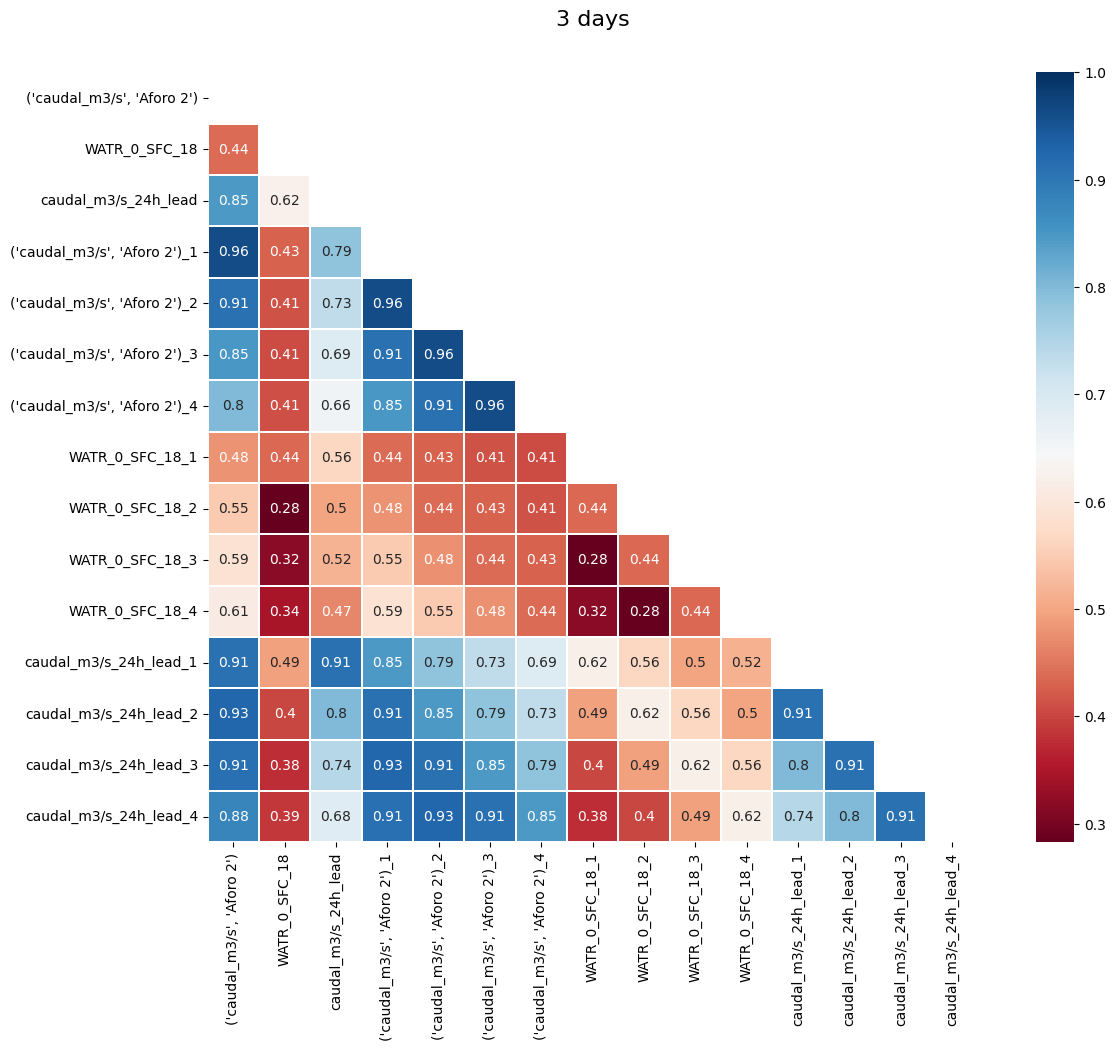

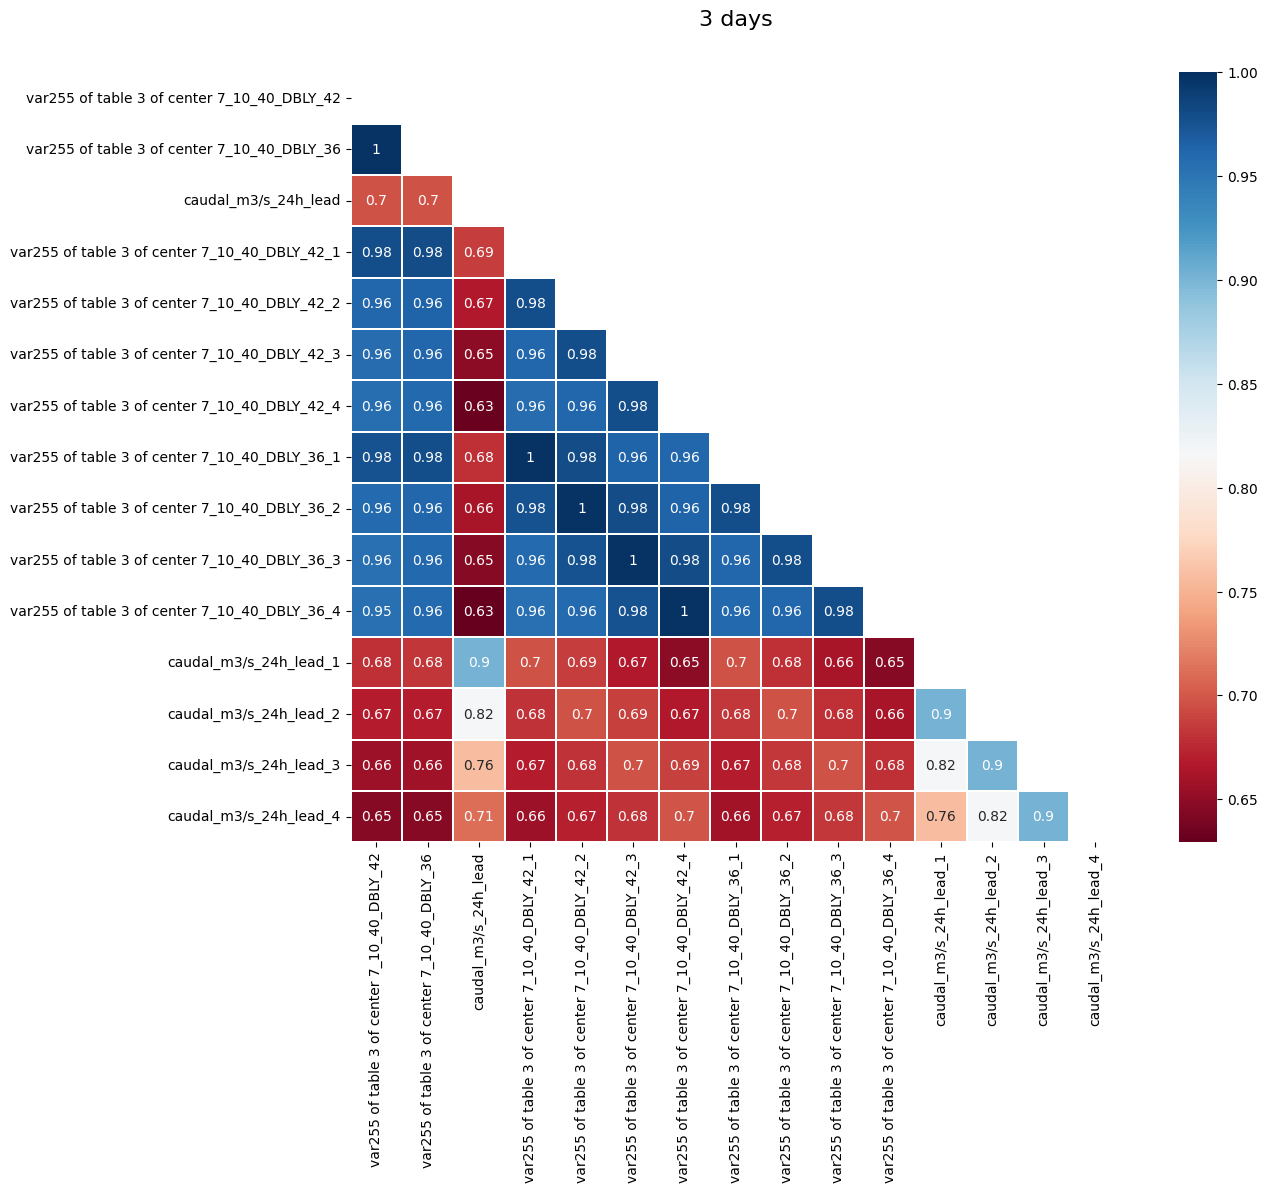

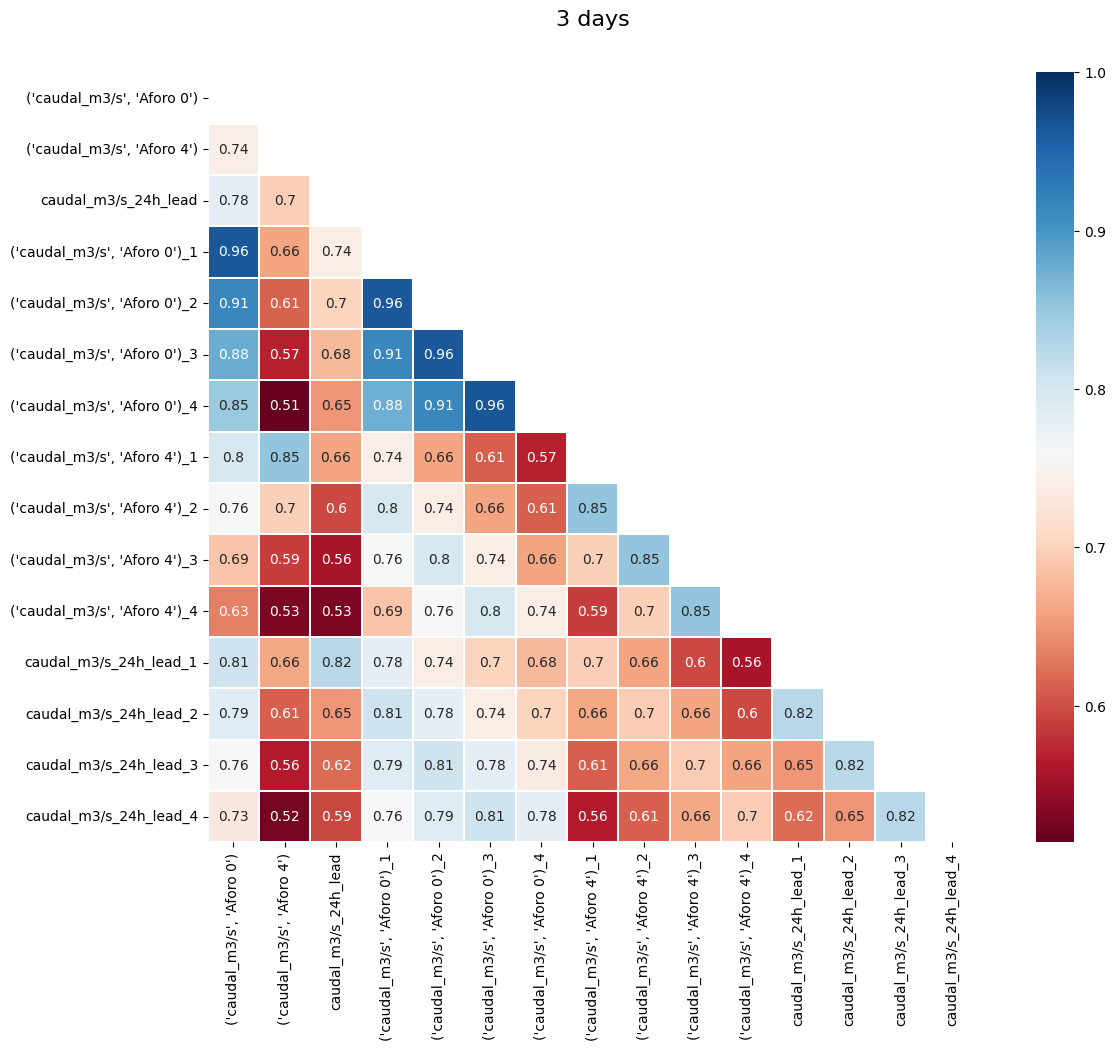

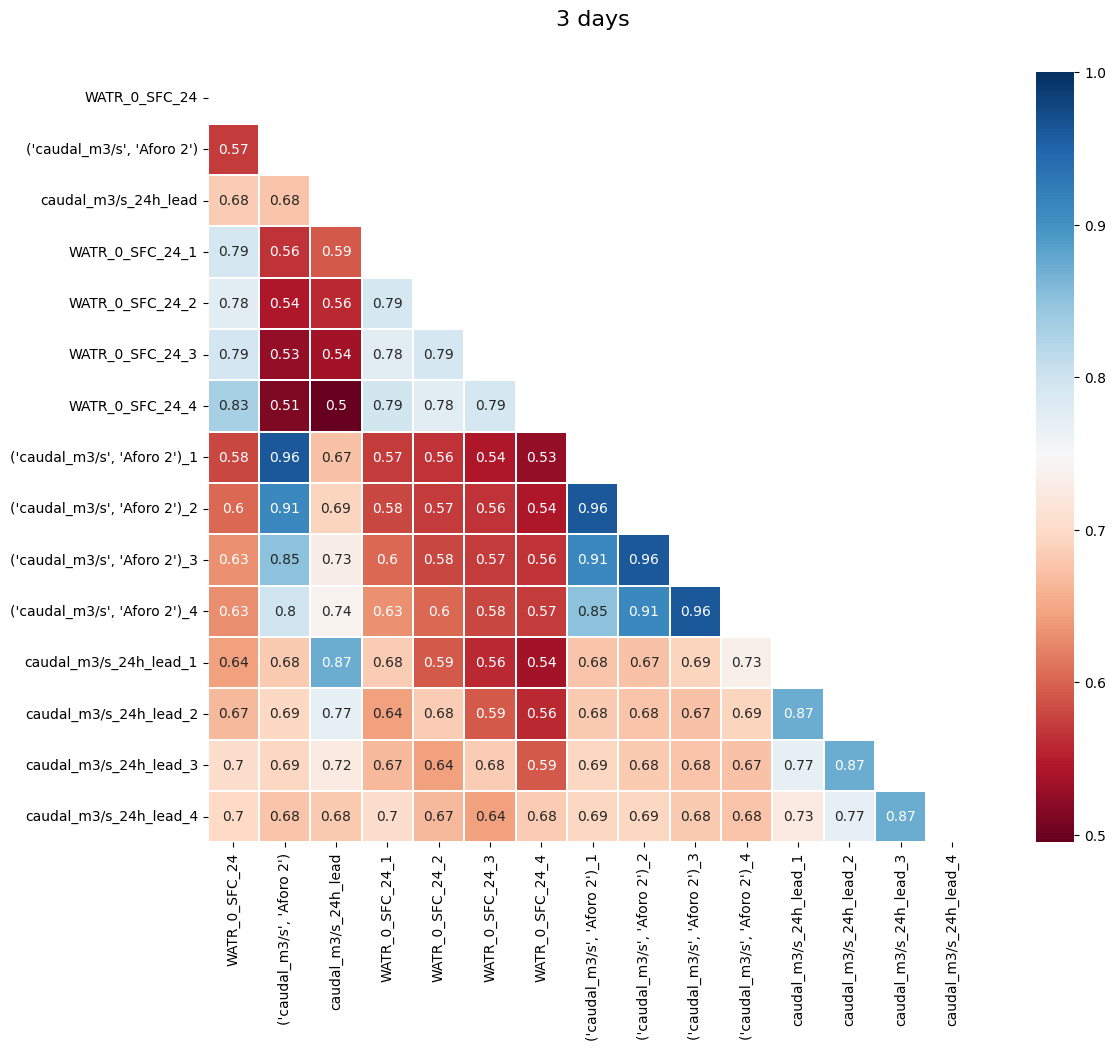

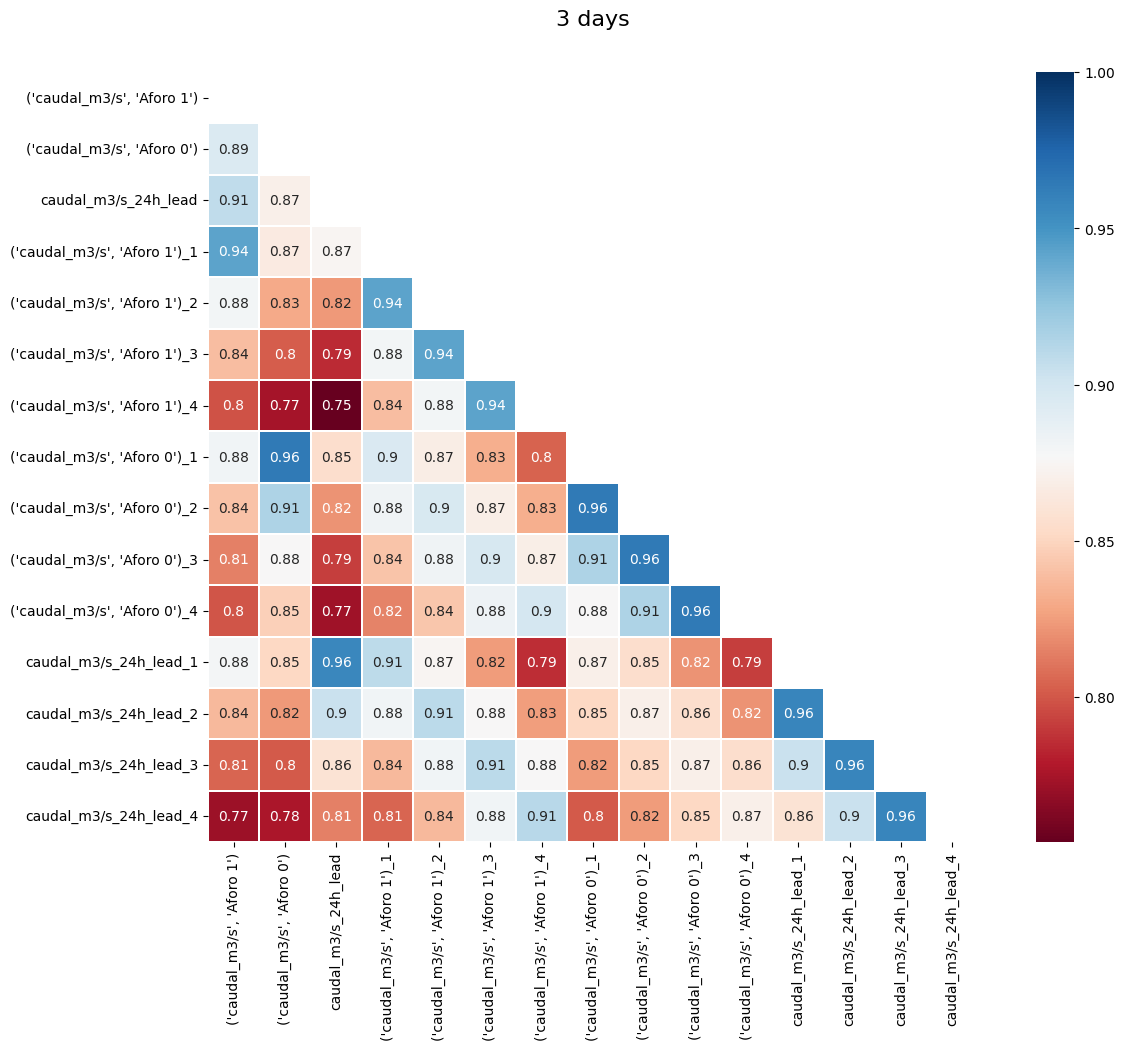

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

for emplazamiento in range(5):
    _, _, df_new = correlation_analysis(emplazamiento)
    
    colormap = plt.cm.RdBu
    plt.figure(figsize=(15,10))
    plt.title(u'3 days', y=1.05, size=16)
    
    mask = np.zeros_like(df_new.corr())
    mask[np.triu_indices_from(mask)] = True
    
    svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True)

### Entrenamiento

In [18]:
model = HidroModel()

In [19]:
for emplazamiento in range(5):
    model_targets_train_0, y_targets_train_0, df_new = correlation_analysis(emplazamiento)
    
    #train_end_date = pd.to_datetime("2023-04-12")
    #df_new_train = df_new[model_targets_0.iloc[4:].index < train_end_date]
    #y_targets_train_0 = y_targets_0[y_targets_0["time"].isin(df_new_train.index)]
    
    model.add_and_train(df_new.drop(df_new.filter(like='caudal_m3/s_24h_lead').columns, axis=1), y_targets_train_0.iloc[4:], emplazamiento)
    # Tras revisar mejor el problema no se permite acceder a las variables
    # pasadas de y. Así que borramos todas las referencias a los lags de caudal_m3/s_24h_lead

/tmp/ipykernel_17/2086230380.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_df_train_0 = pd.concat([model_df_train_0, pd.DataFrame(index=full_date_range.difference(model_df_train_0.index),
/tmp/ipykernel_17/2086230380.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  columns=model_df_train_0.columns)]).sort_index().ffill()
/tmp/ipykernel_17/2086230380.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or 

caudal_m3/s_24h_lead - Avg Train MAE: 0.32193090165272736, Avg Val MAE: 9.762999760474534
caudal_m3/s_48h_lead - Avg Train MAE: 0.3684506639947849, Avg Val MAE: 9.805465902788132


/tmp/ipykernel_17/2086230380.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_df_train_0 = pd.concat([model_df_train_0, pd.DataFrame(index=full_date_range.difference(model_df_train_0.index),
/tmp/ipykernel_17/2086230380.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  columns=model_df_train_0.columns)]).sort_index().ffill()
/tmp/ipykernel_17/2086230380.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or 

caudal_m3/s_24h_lead - Avg Train MAE: 0.12600563149729002, Avg Val MAE: 3.800929613403023


[codecarbon INFO @ 17:24:46] Energy consumed for RAM : 0.000684 kWh. RAM Power : 11.759087562561035 W
[codecarbon INFO @ 17:24:46] Energy consumed for all CPUs : 0.002480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:24:46] 0.003164 kWh of electricity used since the beginning.


caudal_m3/s_48h_lead - Avg Train MAE: 0.14714735157245779, Avg Val MAE: 3.910196984835042


/tmp/ipykernel_17/2086230380.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_df_train_0 = pd.concat([model_df_train_0, pd.DataFrame(index=full_date_range.difference(model_df_train_0.index),
/tmp/ipykernel_17/2086230380.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  columns=model_df_train_0.columns)]).sort_index().ffill()
/tmp/ipykernel_17/2086230380.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or 

caudal_m3/s_24h_lead - Avg Train MAE: 1.289832351676094, Avg Val MAE: 20.503589382873695
caudal_m3/s_48h_lead - Avg Train MAE: 1.5830575704441299, Avg Val MAE: 23.333339720951678


/tmp/ipykernel_17/2086230380.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_df_train_0 = pd.concat([model_df_train_0, pd.DataFrame(index=full_date_range.difference(model_df_train_0.index),
/tmp/ipykernel_17/2086230380.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  columns=model_df_train_0.columns)]).sort_index().ffill()
/tmp/ipykernel_17/2086230380.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or 

caudal_m3/s_24h_lead - Avg Train MAE: 0.012244214394700567, Avg Val MAE: 1.5718044327598357
caudal_m3/s_48h_lead - Avg Train MAE: 0.014031553883120943, Avg Val MAE: 1.096448566728695


/tmp/ipykernel_17/2086230380.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_df_train_0 = pd.concat([model_df_train_0, pd.DataFrame(index=full_date_range.difference(model_df_train_0.index),
/tmp/ipykernel_17/2086230380.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  columns=model_df_train_0.columns)]).sort_index().ffill()
/tmp/ipykernel_17/2086230380.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or 

caudal_m3/s_24h_lead - Avg Train MAE: 0.7336996487291683, Avg Val MAE: 22.700516612992715
caudal_m3/s_48h_lead - Avg Train MAE: 0.7713732956602354, Avg Val MAE: 23.607451783598155


## Generar predicciones para test

In [20]:
# Seleccionar las fechas en las que tenemos que hacer el forecast a 24 y 48 horas
dates_for_pred = [date - pd.DateOffset(days=1) for date in test_dates[::2]]
dates_for_pred

[Timestamp('2023-04-11 00:00:00'),
 Timestamp('2023-05-02 00:00:00'),
 Timestamp('2023-06-07 00:00:00'),
 Timestamp('2023-07-04 00:00:00'),
 Timestamp('2023-07-30 00:00:00'),
 Timestamp('2023-09-04 00:00:00'),
 Timestamp('2023-09-25 00:00:00'),
 Timestamp('2023-11-02 00:00:00'),
 Timestamp('2023-12-02 00:00:00'),
 Timestamp('2023-12-24 00:00:00'),
 Timestamp('2024-01-17 00:00:00'),
 Timestamp('2024-02-11 00:00:00'),
 Timestamp('2024-03-10 00:00:00')]

Usamos los modelos para predecir con los datos de los dias en los que queremos predecir y los guardamos en el formato el que se evaluarán.

In [21]:
# Sobrescribimos get_prediction_index para que funcione con nuestro código
def get_prediction_index(model_df_test: pd.DataFrame, hours_offset: int, emplazamiento: int):
    df_new = pd.DataFrame()
    #df_new['time_name'] = model_df_test.index.strftime('%Y-%m-%d') + f'_Emplazamiento {emplazamiento}'
    
    df_new['time_name'] = (pd.to_datetime(model_df_test.index) + pd.DateOffset(hours=hours_offset)).strftime('%Y-%m-%d') + f'_Emplazamiento {emplazamiento}'
    hours=hours_offset
    return df_new
    
def get_test_emplazamiento(emplazamiento):
    model_df_train_0 = model_df[model_df[f"Emplazamiento {emplazamiento}"] == 1]

    # Fill missing dates
    full_date_range = pd.date_range(start=model_df_train_0.index.min(), end=model_df_train_0.index.max())
    model_df_train_0 = pd.concat([model_df_train_0, pd.DataFrame(index=full_date_range.difference(model_df_train_0.index),
                            columns=model_df_train_0.columns)]).sort_index().ffill()
    
    time_features = ['dayofmonth', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'Year sin', 'Year cos']
    df = df_derived_by_shift(model_df_train_0, 4, time_features)
    #df = df.dropna()    
    return df

In [22]:
# get test predictions
preds = []

for emplazamiento in range(5):
    # Get test with all lags and columns 
    all_model_df_test = get_test_emplazamiento(emplazamiento)
    model_df_test = all_model_df_test[list(model.features[emplazamiento])]
    for name, m in model.models[emplazamiento].items():
        lead = 24 if ("24" in name) else 48
        model_df_test_emp = model_df_test[model_df_test.index.isin(dates_for_pred)]
        pred = m.predict(model_df_test_emp)
        pred = np.clip(pred, 0, None) # replace negative values with 0, the actual values can never be negative so this reduces error
        idx = get_prediction_index(model_df_test_emp, lead, emplazamiento)
        idx["caudal_m3/s"] = pd.Series(pred)
        preds.append(idx)
        
preds = pd.concat(preds, axis =0).reset_index(drop=True)
preds.to_csv("submission.csv", index=False)
preds

/tmp/ipykernel_17/798899396.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_df_train_0 = pd.concat([model_df_train_0, pd.DataFrame(index=full_date_range.difference(model_df_train_0.index),
/tmp/ipykernel_17/798899396.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  columns=model_df_train_0.columns)]).sort_index().ffill()
/tmp/ipykernel_17/798899396.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or 

,time_name,caudal_m3/s
0,2023-04-12_Emplazamiento 0,4.827958
1,2023-05-03_Emplazamiento 0,1.018011
2,2023-06-08_Emplazamiento 0,4.745579
3,2023-07-05_Emplazamiento 0,0.967251
4,2023-07-31_Emplazamiento 0,4.082678
...,...,...
125,2023-12-04_Emplazamiento 4,126.239639
126,2023-12-26_Emplazamiento 4,156.307709
127,2024-01-19_Emplazamiento 4,164.548615
128,2024-02-13_Emplazamiento 4,71.238319


In [23]:
preds[preds.duplicated(keep=False)]

,time_name,caudal_m3/s


Paramos el tracker y podemos ver el consumo total de eléctricidad de nuestro notebook final.

In [24]:
tracker.stop()

[codecarbon INFO @ 17:25:11] Energy consumed for RAM : 0.000767 kWh. RAM Power : 11.759087562561035 W
[codecarbon INFO @ 17:25:11] Energy consumed for all CPUs : 0.002777 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:25:11] 0.003544 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:25:11] 0.002089 g.CO2eq/s mean an estimation of 65.86496866130368 kg.CO2eq/year
/opt/conda/lib/python3.10/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


0.0004917614123763989